<a href="https://colab.research.google.com/github/Kasimer-0/CSCI218_Group-FT32/blob/main/MLP_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
import time
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("DOG BREED MLP CLASSIFICATION - 50 CLASSES")
print("="*60)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


DOG BREED MLP CLASSIFICATION - 50 CLASSES
Mounted at /content/drive


In [ ]:

# 1. Load and Prepare Dataset (50 classes, ~8000 images)
# Dataset paths
zipped_dataset_drive_path = '/content/drive/MyDrive/dog_breed_dataset/50_classes.zip'
local_content_path = '/content/dog_breed_dataset/50_classes'

# Extract dataset if not already extracted
if os.path.exists(local_content_path):
    print(f"Dataset ready: {local_content_path}")
else:
    if not os.path.exists(zipped_dataset_drive_path):
        print(f"Error: Dataset not found")
    else:
        !cp "{zipped_dataset_drive_path}" /content/
        !unzip -q /content/50_classes.zip -d /content/dog_breed_dataset/
        print("Dataset extracted")

DATASET_PATH = local_content_path

Dataset extracted


In [ ]:

# 2. Data Loading Function (Target ~8000 images)

def load_dog_dataset(data_path, num_breeds=50, max_images_per_breed=80):
    """Load dog breed images - target ~8000 total images with augmentation"""

    # Locate Images folder
    if 'Images' in os.listdir(data_path):
        data_path = os.path.join(data_path, 'Images')

    all_breeds = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    all_breeds.sort()
    selected_breeds = all_breeds[:num_breeds]

    images, labels = [], []
    original_count = 0
    augmented_count = 0

    for breed_idx, breed in enumerate(selected_breeds):
        breed_dir = os.path.join(data_path, breed)
        image_files = [f for f in os.listdir(breed_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for file in image_files[:max_images_per_breed]:
            try:
                img_path = os.path.join(breed_dir, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((128, 128))
                img_array = np.array(img)

                if img_array.shape == (128, 128, 3):
                    # Original image
                    images.append(img_array)
                    labels.append(breed_idx)
                    original_count += 1

                    # Horizontal flip
                    flipped = np.fliplr(img_array)
                    images.append(flipped)
                    labels.append(breed_idx)
                    augmented_count += 1

                    # Color jitter (brightness)
                    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV).astype(np.float32)
                    hsv[:, :, 2] *= 0.9
                    darker = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
                    images.append(darker)
                    labels.append(breed_idx)
                    augmented_count += 1

                    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV).astype(np.float32)
                    hsv[:, :, 2] *= 1.1
                    brighter = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
                    images.append(brighter)
                    labels.append(breed_idx)
                    augmented_count += 1

            except Exception as e:
                continue

    print(f"\nDataset Statistics:")
    print(f"  Original images: {original_count}")
    print(f"  Augmented images: {augmented_count}")
    print(f"  Total images: {len(images)}")
    print(f"  Breeds: {len(selected_breeds)}")

    return np.array(images), np.array(labels), selected_breeds


In [ ]:

# 3. Load Dataset
print("\n" + "-"*40)
print("LOADING DATASET")
print("-"*40)

images, labels, breed_names = load_dog_dataset(
    DATASET_PATH,
    num_breeds=50,
    max_images_per_breed=40
)



----------------------------------------
LOADING DATASET
----------------------------------------

Dataset Statistics:
  Original images: 2000
  Augmented images: 6000
  Total images: 8000
  Breeds: 50


In [ ]:

# 4. Train/Validation/Test Split (80/10/10)
print("\n" + "-"*40)
print("DATA SPLIT")
print("-"*40)

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Second split: 50% of temp = 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training:   {len(X_train):5d} images")
print(f"Validation: {len(X_val):5d} images")
print(f"Test:       {len(X_test):5d} images")
print(f"Total:      {len(X_train)+len(X_val)+len(X_test):5d} images")



----------------------------------------
DATA SPLIT
----------------------------------------
Training:    6400 images
Validation:   800 images
Test:         800 images
Total:       8000 images


In [ ]:

# 5. Optimized Feature Extractor for MLP
class OptimizedFeatureExtractor:
    """Feature extractor optimized for 50-class classification"""

    def extract_features(self, image):
        features = []
        image = cv2.resize(image, (128, 128))

        # 1. HSV color histograms - reduced dimensions
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        h_hist = cv2.calcHist([hsv], [0], None, [16], [0, 180])
        s_hist = cv2.calcHist([hsv], [1], None, [8], [0, 256])
        v_hist = cv2.calcHist([hsv], [2], None, [8], [0, 256])

        h_hist = h_hist.flatten() / (h_hist.sum() + 1e-7)
        s_hist = s_hist.flatten() / (s_hist.sum() + 1e-7)
        v_hist = v_hist.flatten() / (v_hist.sum() + 1e-7)

        features.extend(h_hist)
        features.extend(s_hist)
        features.extend(v_hist)

        # 2. Color statistics
        for channel in range(3):
            channel_data = image[:, :, channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.percentile(channel_data, 25),
                np.percentile(channel_data, 75),
            ])

        # 3. Texture features
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Sobel gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

        features.extend([
            np.mean(gradient_magnitude),
            np.std(gradient_magnitude),
        ])

        # 4. Edge features
        edges = cv2.Canny(gray, 50, 150)
        features.append(np.sum(edges > 0) / edges.size)

        # 5. Local Binary Pattern-like features (grid-based)
        h, w = gray.shape
        grid_size = 4
        cell_h, cell_w = h // grid_size, w // grid_size

        for i in range(grid_size):
            for j in range(grid_size):
                cell = gray[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
                features.extend([
                    np.mean(cell),
                    np.std(cell),
                ])

        return np.array(features)

    def extract_batch_features(self, images):
        features_list = []
        for img in images:
            features = self.extract_features(img)
            features_list.append(features)
        return np.array(features_list)



In [ ]:
# 6. MLP Classifier

class DogBreedMLP:
    """MLP classifier optimized for 50-class dog breed classification"""

    def __init__(self):
        self.feature_extractor = OptimizedFeatureExtractor()
        self.scaler = StandardScaler()

        # Optimized MLP architecture for 50 classes
        self.mlp = MLPClassifier(
            hidden_layer_sizes=(512, 256, 128),  # Deeper network for 50 classes
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size=64,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=42,
            verbose=False
        )

        self.breed_names = []

    def train(self, X_train, y_train, X_val, y_val):
        print("\nExtracting features...")
        start_time = time.time()

        X_train_features = self.feature_extractor.extract_batch_features(X_train)
        X_val_features = self.feature_extractor.extract_batch_features(X_val)

        print(f"Feature dimension: {X_train_features.shape[1]}")
        print(f"Training samples: {X_train_features.shape[0]}")

        print("Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train_features)
        X_val_scaled = self.scaler.transform(X_val_features)

        print("Training MLP (this may take 2-3 minutes)...")
        self.mlp.fit(X_train_scaled, y_train)

        train_time = time.time() - start_time
        print(f"Training time: {train_time:.1f} seconds")

        # Training accuracy
        train_pred = self.mlp.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)

        # Validation accuracy
        val_pred = self.mlp.predict(X_val_scaled)
        val_acc = accuracy_score(y_val, val_pred)

        print(f"Training accuracy: {train_acc:.4f}")
        print(f"Validation accuracy: {val_acc:.4f}")

        return train_acc, val_acc

    def evaluate(self, X_test, y_test):
        features = self.feature_extractor.extract_batch_features(X_test)
        features_scaled = self.scaler.transform(features)
        predictions = self.mlp.predict(features_scaled)
        accuracy = accuracy_score(y_test, predictions)
        return accuracy, predictions

    def predict(self, X):
        features = self.feature_extractor.extract_batch_features(X)
        features_scaled = self.scaler.transform(features)
        return self.mlp.predict(features_scaled)


In [ ]:

# 7. Train MLP Model
print("\n" + "-"*40)
print("TRAINING MLP CLASSIFIER")
print("-"*40)

mlp_classifier = DogBreedMLP()
mlp_classifier.breed_names = breed_names

train_acc, val_acc = mlp_classifier.train(X_train, y_train, X_val, y_val)



----------------------------------------
TRAINING MLP CLASSIFIER
----------------------------------------

Extracting features...
Feature dimension: 79
Training samples: 6400
Scaling features...
Training MLP (this may take 2-3 minutes)...
Training time: 133.9 seconds
Training accuracy: 0.9827
Validation accuracy: 0.8275


In [ ]:

# 8. Test Set Evaluation
print("\n" + "-"*40)
print("TEST SET EVALUATION")
print("-"*40)

test_accuracy, y_pred = mlp_classifier.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")



----------------------------------------
TEST SET EVALUATION
----------------------------------------
Test accuracy: 0.8163 (81.62%)


In [ ]:

# 9. Classification Report (All 50 breeds)
print("\nClassification Report (All 50 breeds):")
print("="*70)
print(classification_report(y_test, y_pred,
                          target_names=breed_names,
                          digits=3))



Classification Report (All 50 breeds):
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua      0.824     0.875     0.848        16
              n02085782-Japanese_spaniel      0.812     0.812     0.812        16
                   n02085936-Maltese_dog      0.867     0.812     0.839        16
                      n02086079-Pekinese      0.846     0.688     0.759        16
                      n02086240-Shih-Tzu      1.000     0.875     0.933        16
              n02086646-Blenheim_spaniel      0.923     0.750     0.828        16
                      n02086910-papillon      0.833     0.938     0.882        16
                   n02087046-toy_terrier      0.650     0.812     0.722        16
           n02087394-Rhodesian_ridgeback      0.800     0.750     0.774        16
                  n02088094-Afghan_hound      0.692     0.562     0.621        16
                        n02088238-basset      0.765     0

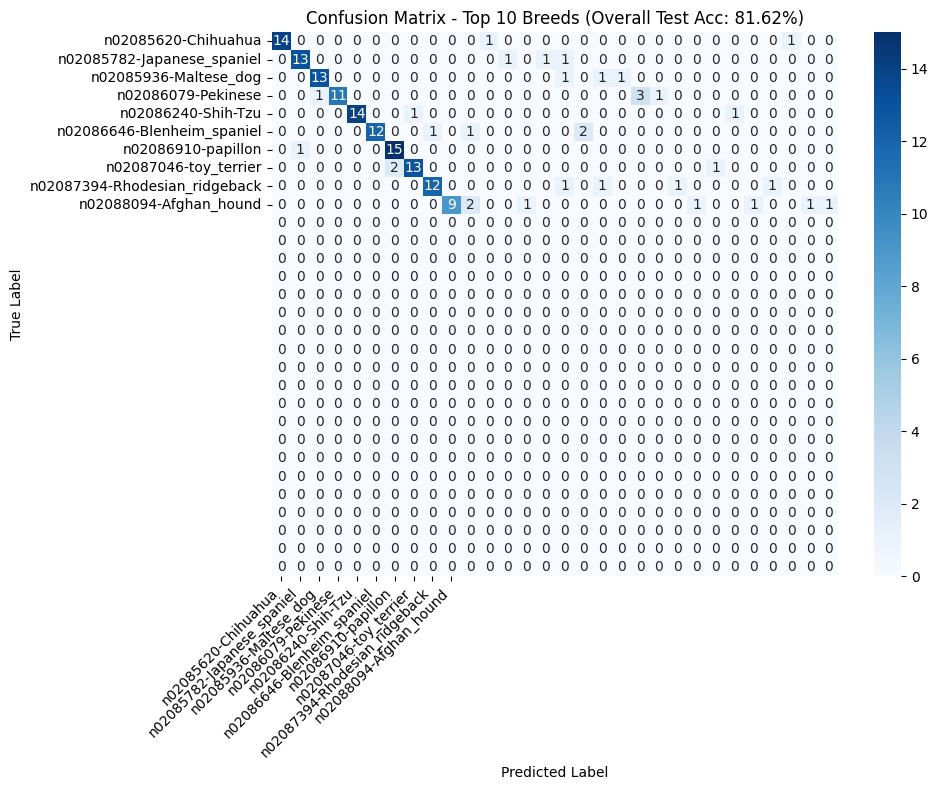

In [ ]:

# 10. Confusion Matrix (Top 10 breeds)

unique_test_classes = np.unique(y_test)
top_breeds_indices = unique_test_classes[:10]
top_breeds_names = [breed_names[i] for i in top_breeds_indices]

mask = np.isin(y_test, top_breeds_indices)
y_test_top = y_test[mask]
y_pred_top = y_pred[mask]

cm = confusion_matrix(y_test_top, y_pred_top)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_breeds_names,
            yticklabels=top_breeds_names)
plt.title(f'Confusion Matrix - Top 10 Breeds (Overall Test Acc: {test_accuracy:.2%})',
          fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

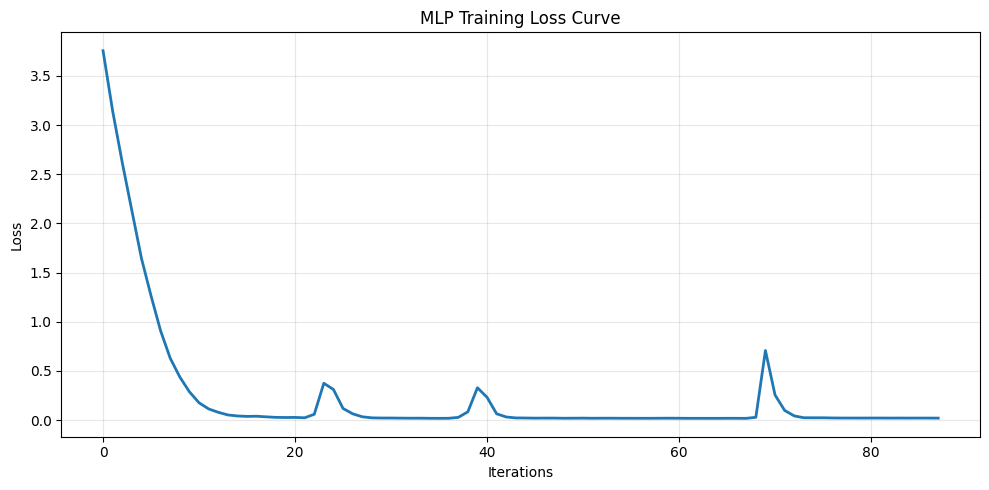

In [ ]:

# 11. Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(mlp_classifier.mlp.loss_curve_, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



----------------------------------------
TRAINING VS VALIDATION ACCURACY
----------------------------------------


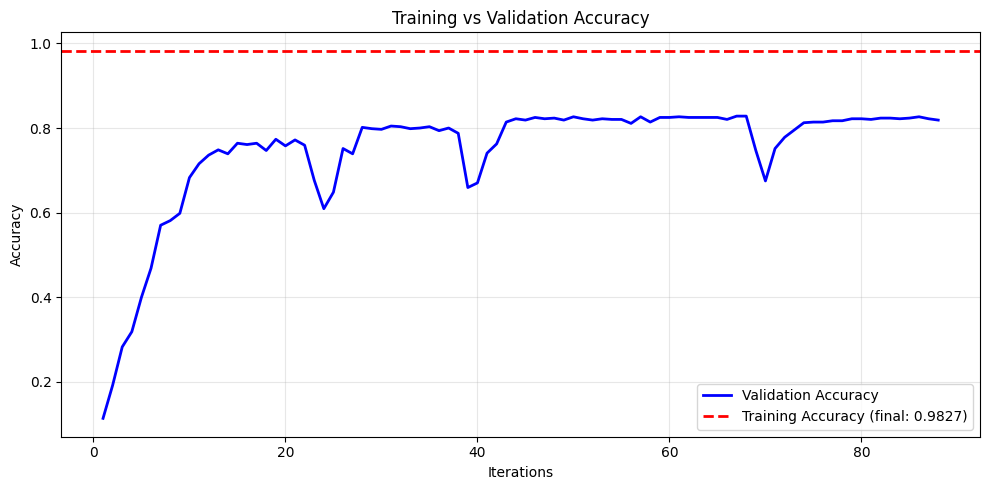

   • Final validation accuracy: 0.8187
   • Best validation accuracy: 0.8281


In [ ]:
# 12. Training vs Validation Accuracy Curve
print("\n" + "-"*40)
print("TRAINING VS VALIDATION ACCURACY")
print("-"*40)

if hasattr(mlp_classifier.mlp, 'validation_scores_'):
    val_scores = mlp_classifier.mlp.validation_scores_
    iterations = range(1, len(val_scores) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, val_scores, 'b-', linewidth=2, label='Validation Accuracy')
    plt.axhline(y=train_acc, color='r', linestyle='--', linewidth=2,
                label=f'Training Accuracy (final: {train_acc:.4f})')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"   • Final validation accuracy: {val_scores[-1]:.4f}")
    print(f"   • Best validation accuracy: {max(val_scores):.4f}")
else:

    print("Note: Detailed validation scores not available from MLPClassifier")
    print(f"   • Training accuracy: {train_acc:.4f}")
    print(f"   • Validation accuracy: {val_acc:.4f}")

    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Training', 'Validation'], [train_acc, val_acc],
                   color=['blue', 'orange'])
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')


    for bar, acc in zip(bars, [train_acc, val_acc]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


----------------------------------------
SAMPLE PREDICTIONS
----------------------------------------


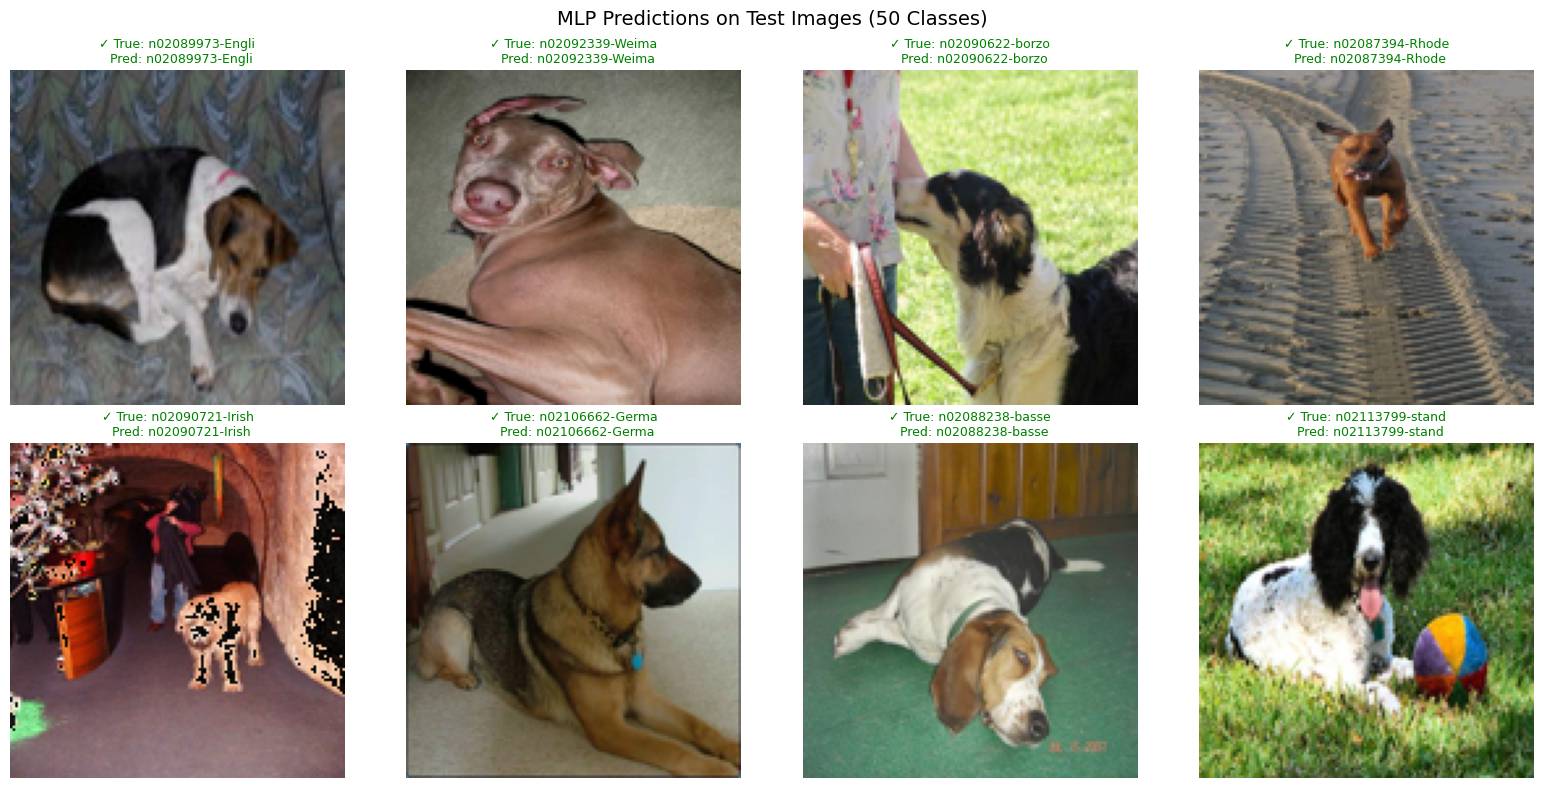

In [ ]:

# 13. Sample Predictions Visualization
print("\n" + "-"*40)
print("SAMPLE PREDICTIONS")
print("-"*40)

# Random test samples
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('MLP Predictions on Test Images (50 Classes)', fontsize=14)

for i, ax in enumerate(axes.flat):
    idx = sample_indices[i]
    ax.imshow(X_test[idx].astype(np.uint8))

    true_label = breed_names[y_test[idx]]
    pred_label = breed_names[y_pred[idx]]

    color = 'green' if y_test[idx] == y_pred[idx] else 'red'
    marker = '✓' if y_test[idx] == y_pred[idx] else '✗'

    ax.set_title(f'{marker} True: {true_label[:15]}\n  Pred: {pred_label[:15]}',
                color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# 14. Performance Summary

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

print("\n DATASET STATISTICS:")
print(f"   • Number of breeds: {len(breed_names)}")
print(f"   • Total images: {len(images)}")
print(f"   • Training set: {len(X_train)} images")
print(f"   • Validation set: {len(X_val)} images")
print(f"   • Test set: {len(X_test)} images")

print("\n MODEL PERFORMANCE:")
print(f"   • Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   • Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   • Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Training iterations: {mlp_classifier.mlp.n_iter_}")
print(f"   • Final loss: {mlp_classifier.mlp.loss_:.4f}")




PERFORMANCE SUMMARY

 DATASET STATISTICS:
   • Number of breeds: 50
   • Total images: 8000
   • Training set: 6400 images
   • Validation set: 800 images
   • Test set: 800 images

 MODEL PERFORMANCE:
   • Training accuracy: 0.9827 (98.27%)
   • Validation accuracy: 0.8275 (82.75%)
   • Test accuracy: 0.8163 (81.62%)
   • Training iterations: 88
   • Final loss: 0.0207
